In [ ]:
# download and update library
!git clone https://github.com/Kemsekov/kemsekov_torch
!cd kemsekov_torch && git pull

Cloning into 'kemsekov_torch'...
remote: Enumerating objects: 1538, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 1538 (delta 44), reused 52 (delta 22), pack-reused 1462 (from 2)
Receiving objects: 100% (1538/1538), 456.68 KiB | 1.18 MiB/s, done.
Resolving deltas: 100% (989/989), done.
Already up to date.


In [ ]:
# download dataset for classification
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

# path to folder with images folders
images_folder = os.path.join(path,'seg_train','seg_train')

Path to dataset files: /home/vlad/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [ ]:
from random import shuffle
import random
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from kemsekov_torch.train import split_dataset

# train image size
TRAIN_IMAGE_SIZE=(128,128)

def crop_or_resize(x):
    x = T.Resize((max(TRAIN_IMAGE_SIZE)+32),T.InterpolationMode.NEAREST_EXACT)(x)
    return T.RandomCrop(TRAIN_IMAGE_SIZE)(x)

def channels_permute(x):
    ind = [0,1,2]
    shuffle(ind)
    return x[ind]

def random_square_channel(x):
    if random.randint(0,5)==0:
        ind = random.randint(0,2)
        x[ind]*=x[ind]
    return x

interpolation = T.InterpolationMode.NEAREST
# transformation for input image
tr = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x[:3]),
    T.Lambda(crop_or_resize),
    T.Lambda(channels_permute),
    T.Lambda(random_square_channel),
    T.ColorJitter(0.7,0.7,0.7),
    T.RandomGrayscale(0.01),
    T.RandomHorizontalFlip(),
])

dataset = ImageFolder(images_folder,transform=tr)
random_state = 123
torch.random.manual_seed(random_state)
random.seed(random_state)

# split dataset into train and test
train_dataset,test_dataset,train_loader, test_loader = split_dataset(
    dataset,
    test_size=0.05,
    num_workers=32,
    batch_size=64,
    startify=dataset.targets,
    random_state=random_state
)
print(f"Train images",len(train_dataset),"\nTest images",len(test_dataset),"\nClasses count",len(dataset.classes))

Train images 13332 
Test images 702 
Classes count 6


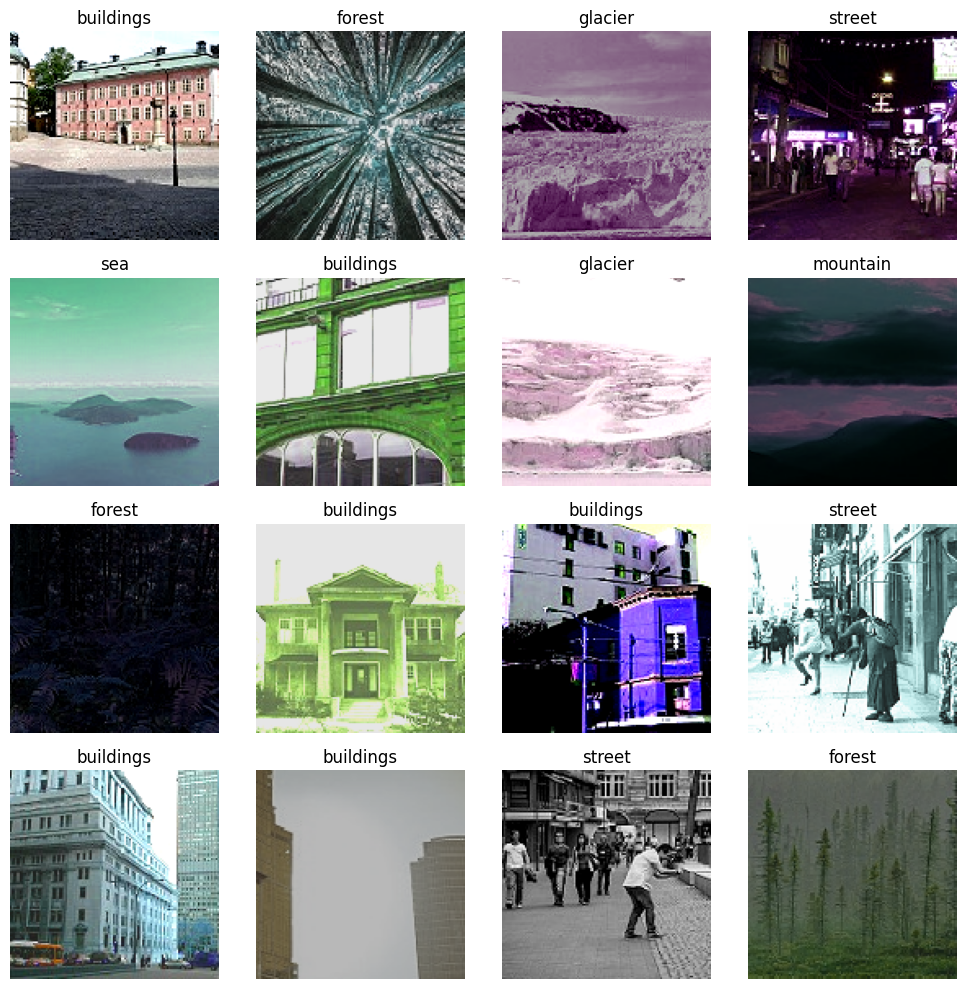

In [13]:
import matplotlib.pyplot as plt
from random import randint

# Set up a 4x4 grid for displaying images
plt.figure(figsize=(10,10))

for i in range(4):
    for j in range(4):
        index = randint(0, len(dataset) - 1)       # Random index from dataset
        sample = dataset[index]                    # Select a random sample
        image, label = sample[0], sample[1]        # Separate image and label
        plt.subplot(4,4,i*4+j+1)
        plt.title(dataset.classes[label])
        # Display image on the selected subplot
        plt.imshow(T.ToPILImage()(image))
        plt.axis("off")                             # Hide axes for clean view

plt.tight_layout()
plt.show()

In [ ]:
from kemsekov_torch.residual import ResidualBlock
from kemsekov_torch.train import *
from kemsekov_torch.linear_attention_imports import *
from kemsekov_torch.attention import EfficientSpatialChannelAttention
import torch.nn as nn
from torchmetrics import Accuracy,F1Score
import warnings
warnings.filterwarnings("ignore")
num_classes = len(dataset.classes)

# define model as a sequential of convolution blocks and spatial channel attentions
common = dict(kernel_size=4,stride=2,normalization='group')
m = nn.Sequential(
    ResidualBlock(3,64,**common),
    EfficientSpatialChannelAttention(64),
    
    ResidualBlock(64,128,**common),
    EfficientSpatialChannelAttention(128),
    
    ResidualBlock(128,256,**common),
    EfficientSpatialChannelAttention(256),
    
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(1),
    nn.Linear(256,num_classes)
)

loss = nn.CrossEntropyLoss()
acc = Accuracy('multiclass',num_classes=num_classes)
f1 = F1Score('multiclass',average='macro',num_classes=num_classes)

# define loss function and metric
def loss_and_metric(model,batch):
    ims,label = batch[0],batch[1]
    pred = model(ims)
    
    loss_ = loss(pred,label)
    pred_d = pred.cpu().detach()
    label_d = label.cpu().detach()
    
    acc_ = acc(pred_d,label_d)
    f1_ = f1(pred_d,label_d)
    return loss_,{
        'acc':acc_,
        'f1_macro':f1_
    }

# train model
path = 'runs/classification'
_ = train(
    m,
    train_loader,
    test_loader,
    loss_and_metric,
    path,
    # f"{path}/last",
    num_epochs=20,
    save_on_metric_improve=['f1_macro'],
    accelerate_args={
        'mixed_precision':'bf16',
        'dynamo_backend':'inductor'
    },
    gradient_clipping_max_norm=1
)

Total model parameters 1.75 M
trying to capture model architecture...
Saved model architecture at runs/classification/model.pt. You can torch.load it and update it's weights with checkpoint

Epoch 1/20


train 0: 100%|██████████| 209/209 [00:32<00:00,  6.50it/s, acc=0.3000, f1_macro=0.1778, loss=1.3893]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 1.74959 | 1.49757 |
|   acc    | 0.2453  | 0.3635  |
| f1_macro | 0.1595  | 0.3028  |
+----------+---------+---------+
saved epoch-1

Epoch 2/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.24it/s, acc=0.6000, f1_macro=0.5480, loss=1.3153]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 1.30899 | 1.26247 |
|   acc    | 0.4511  | 0.4759  |
| f1_macro | 0.4000  | 0.4481  |
+----------+---------+---------+
saved epoch-2

Epoch 3/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.41it/s, acc=0.5500, f1_macro=0.4422, loss=1.0766]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.99614 | 0.94137 |
|   acc    | 0.6054  | 0.6085  |
| f1_macro | 0.5836  | 0.5896  |
+----------+---------+---------+
saved epoch-3

Epoch 4/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.00it/s, acc=0.7000, f1_macro=0.5888, loss=0.8671]


+----------+---------+--------+
|          |  Train  |  Test  |
+----------+---------+--------+
|   loss   | 0.81399 | 0.8288 |
|   acc    | 0.6831  | 0.6768 |
| f1_macro | 0.6696  | 0.6642 |
+----------+---------+--------+
saved epoch-4

Epoch 5/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.12it/s, acc=0.6000, f1_macro=0.4468, loss=0.9114]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.73071 | 0.75825 |
|   acc    | 0.7189  | 0.7136  |
| f1_macro | 0.7073  | 0.7068  |
+----------+---------+---------+
saved epoch-5

Epoch 6/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.22it/s, acc=0.8000, f1_macro=0.7752, loss=0.5944]


+----------+--------+---------+
|          | Train  |  Test   |
+----------+--------+---------+
|   loss   | 0.6664 | 0.73345 |
|   acc    | 0.7452 | 0.7278  |
| f1_macro | 0.7362 | 0.7222  |
+----------+--------+---------+
saved epoch-6

Epoch 7/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.28it/s, acc=0.7000, f1_macro=0.5859, loss=0.7520]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.63843 | 0.69114 |
|   acc    | 0.7618  | 0.7378  |
| f1_macro | 0.7532  | 0.7312  |
+----------+---------+---------+
saved epoch-7

Epoch 8/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.39it/s, acc=0.6000, f1_macro=0.5056, loss=0.5904]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.59178 | 0.61434 |
|   acc    | 0.7725  | 0.7691  |
| f1_macro | 0.7631  | 0.7656  |
+----------+---------+---------+
saved epoch-8

Epoch 9/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.25it/s, acc=0.7500, f1_macro=0.6737, loss=0.4706]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.56222 | 0.63677 |
|   acc    | 0.7858  | 0.7521  |
| f1_macro | 0.7772  | 0.7410  |
+----------+---------+---------+

Epoch 10/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.29it/s, acc=0.8000, f1_macro=0.7632, loss=0.5722]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.54379 | 0.64084 |
|   acc    | 0.7952  | 0.7664  |
| f1_macro | 0.7880  | 0.7641  |
+----------+---------+---------+

Epoch 11/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.21it/s, acc=0.8000, f1_macro=0.7700, loss=0.4739]


+----------+---------+--------+
|          |  Train  |  Test  |
+----------+---------+--------+
|   loss   | 0.51879 | 0.6016 |
|   acc    | 0.8016  | 0.7862 |
| f1_macro | 0.7945  | 0.7771 |
+----------+---------+--------+
saved epoch-11

Epoch 12/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 37.58it/s, acc=0.9000, f1_macro=0.9096, loss=0.3591]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.49481 | 0.55125 |
|   acc    | 0.8144  | 0.7988  |
| f1_macro | 0.8084  | 0.7953  |
+----------+---------+---------+
saved epoch-12

Epoch 13/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 37.35it/s, acc=0.9000, f1_macro=0.9096, loss=0.3345]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.48433 | 0.52761 |
|   acc    | 0.8182  | 0.8076  |
| f1_macro | 0.8138  | 0.8059  |
+----------+---------+---------+
saved epoch-13

Epoch 14/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.01it/s, acc=0.9000, f1_macro=0.7361, loss=0.2628]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.46297 | 0.55043 |
|   acc    | 0.8216  | 0.8019  |
| f1_macro | 0.8152  | 0.7980  |
+----------+---------+---------+

Epoch 15/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.26it/s, acc=0.8500, f1_macro=0.8561, loss=0.4438]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.44925 | 0.50308 |
|   acc    | 0.8306  | 0.8175  |
| f1_macro | 0.8257  | 0.8147  |
+----------+---------+---------+
saved epoch-15

Epoch 16/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.35it/s, acc=0.8500, f1_macro=0.8270, loss=0.3741]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.44259 | 0.47054 |
|   acc    | 0.8347  | 0.8389  |
| f1_macro | 0.8285  | 0.8374  |
+----------+---------+---------+
saved epoch-16

Epoch 17/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.27it/s, acc=0.8500, f1_macro=0.7348, loss=0.3694]


+----------+---------+--------+
|          |  Train  |  Test  |
+----------+---------+--------+
|   loss   | 0.42349 | 0.5207 |
|   acc    | 0.8388  | 0.8161 |
| f1_macro | 0.8320  | 0.8146 |
+----------+---------+--------+

Epoch 18/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.18it/s, acc=0.8500, f1_macro=0.6972, loss=0.2519]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.42703 | 0.50374 |
|   acc    | 0.8405  | 0.8346  |
| f1_macro | 0.8357  | 0.8299  |
+----------+---------+---------+

Epoch 19/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.33it/s, acc=0.9000, f1_macro=0.9096, loss=0.3219]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.45353 | 0.46021 |
|   acc    | 0.8288  | 0.8347  |
| f1_macro | 0.8232  | 0.8347  |
+----------+---------+---------+

Epoch 20/20


train 0: 100%|██████████| 209/209 [00:05<00:00, 38.29it/s, acc=0.9500, f1_macro=0.9111, loss=0.1627]


+----------+---------+---------+
|          |  Train  |  Test   |
+----------+---------+---------+
|   loss   | 0.39373 | 0.49468 |
|   acc    | 0.8530  | 0.8389  |
| f1_macro | 0.8484  | 0.8370  |
+----------+---------+---------+


OptimizedModule(
  (_orig_mod): Sequential(
    (0): ResidualBlock(
      (dropout): Dropout2d(p=0.0, inplace=False)
      (x_linear): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=replicate)
        (1): GroupNorm(2, 64, eps=1e-05, affine=True)
      )
      (convs): ModuleList(
        (0): ModuleList(
          (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=replicate)
        )
      )
      (norms): ModuleList(
        (0): GroupNorm(2, 64, eps=1e-05, affine=True)
      )
      (activation): ModuleList(
        (0): SiLU(inplace=True)
      )
    )
    (1): EfficientSpatialChannelAttention(
      (spatial_attn): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): Tanh()
      )
    )
    (2): ResidualBlock(
      (dropout): Dropout2d(p=0.0, inplace=False)
      (x_linear): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2

loading runs/classification/checkpoints/epoch-16/state


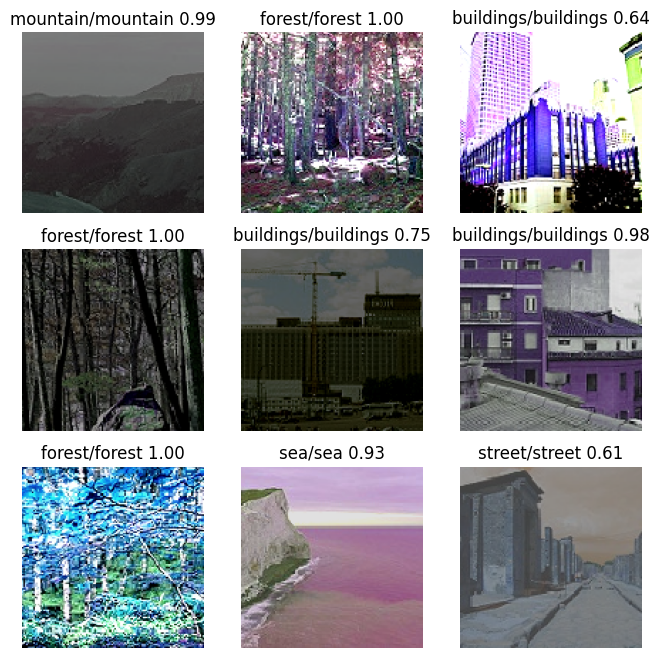

In [37]:
from kemsekov_torch.train import load_best_checkpoint
model = torch.jit.load("runs/classification/model.pt")
model = load_best_checkpoint(model,'runs/classification/').eval().cpu()

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    sample = dataset[random.randint(0,len(dataset)-1)]
    pred_prob = model(sample[0][None,:])[0].softmax(-1)
    pred_class = pred_prob.argmax(-1)
    pred_class_prob = pred_prob[pred_class]
    
    true_label = dataset.classes[sample[1]]
    pred_label = dataset.classes[pred_class]
    plt.imshow(T.ToPILImage()(sample[0]))
    plt.title(f"{true_label}/{pred_label} {pred_class_prob:0.2f}")
    plt.axis('off')